In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import os
from matplotlib.pyplot import imshow
%matplotlib inline

IMAGE_W = 800 
IMAGE_H = 600 
CONTENT_IMG =  './Images/copenhagen.jpg'
STYLE_IMG = './images/sean_phillips_fatale.jpg'
OUTOUT_DIR = './Results'
OUTPUT_IMG = 'results.png'
VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
INI_NOISE_RATIO = 0.1
STYLE_STRENGTH = 1200
ITERATION = 1000

CONTENT_LAYERS =[('conv4_2',1.)]
# To obtain softer features increase higher layers weight and decrease lower layers weight.
# For harder features do the opposite.
STYLE_LAYERS=[('conv1_1',1.),('conv2_1',1.),('conv3_1',1.),('conv4_1',1.),('conv5_1',1.)]


#MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

In [17]:
def build_net(ntype, nin, nwb=None):
    if ntype == 'conv':
        return tf.nn.relu(tf.nn.conv2d(nin, nwb[0], strides=[1, 1, 1, 1], padding='SAME')+ nwb[1])
    elif ntype == 'pool':
        return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1],
                  strides=[1, 2, 2, 1], padding='SAME')

# Weights and bias from the VGG model for a given layer.
def get_weight_bias(vgg_layers, i,):
    #weights = vgg_layers[i][0][0][0][0][0]
    weights = vgg_layers[0,i][0]['weights'][0][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[0,i][0]['weights'][0][0][1]
    bias = tf.constant(np.reshape(bias, (bias.size)))
    return weights, bias

def build_vgg19(path):
    """
    Detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    net = {}
    vgg_rawnet = scipy.io.loadmat(path)
    vgg_layers = vgg_rawnet['layers']
    net['input'] = tf.Variable(np.zeros((1, IMAGE_H, IMAGE_W, 3)).astype('float32'))
    net['conv1_1'] = build_net('conv',net['input'],get_weight_bias(vgg_layers,0))
    net['conv1_2'] = build_net('conv',net['conv1_1'],get_weight_bias(vgg_layers,2))
    net['pool1']   = build_net('pool',net['conv1_2'])
    net['conv2_1'] = build_net('conv',net['pool1'],get_weight_bias(vgg_layers,5))
    net['conv2_2'] = build_net('conv',net['conv2_1'],get_weight_bias(vgg_layers,7))
    net['pool2']   = build_net('pool',net['conv2_2'])
    net['conv3_1'] = build_net('conv',net['pool2'],get_weight_bias(vgg_layers,10))
    net['conv3_2'] = build_net('conv',net['conv3_1'],get_weight_bias(vgg_layers,12))
    net['conv3_3'] = build_net('conv',net['conv3_2'],get_weight_bias(vgg_layers,14))
    net['conv3_4'] = build_net('conv',net['conv3_3'],get_weight_bias(vgg_layers,16))
    net['pool3']   = build_net('pool',net['conv3_4'])
    net['conv4_1'] = build_net('conv',net['pool3'],get_weight_bias(vgg_layers,19))
    net['conv4_2'] = build_net('conv',net['conv4_1'],get_weight_bias(vgg_layers,21))
    net['conv4_3'] = build_net('conv',net['conv4_2'],get_weight_bias(vgg_layers,23))
    net['conv4_4'] = build_net('conv',net['conv4_3'],get_weight_bias(vgg_layers,25))
    net['pool4']   = build_net('pool',net['conv4_4'])
    net['conv5_1'] = build_net('conv',net['pool4'],get_weight_bias(vgg_layers,28))
    net['conv5_2'] = build_net('conv',net['conv5_1'],get_weight_bias(vgg_layers,30))
    net['conv5_3'] = build_net('conv',net['conv5_2'],get_weight_bias(vgg_layers,32))
    net['conv5_4'] = build_net('conv',net['conv5_3'],get_weight_bias(vgg_layers,34))
    net['pool5']   = build_net('pool',net['conv5_4'])
    return net

def build_content_loss(p, x):
  M = p.shape[1]*p.shape[2]
  N = p.shape[3]
  loss = (1./(2* N**0.5 * M**0.5 )) * tf.reduce_sum(tf.pow((x - p),2))  
  return loss


def gram_matrix(x, area, depth):
  x1 = tf.reshape(x,(area,depth))
  g = tf.matmul(tf.transpose(x1), x1)
  return g

def gram_matrix_val(x, area, depth):
  x1 = x.reshape(area,depth)
  g = np.dot(x1.T, x1)
  return g

def build_style_loss(a, x):
  # M is the height times the width of the feature map.
  M = a.shape[1]*a.shape[2]
  # N is the number of filters.    
  N = a.shape[3]
  # A is the style representation of the original image.  
  A = gram_matrix_val(a, M, N )
  # G is the style representation of the generated image.
  G = gram_matrix(x, M, N )
  loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A),2))
  return loss


def read_image(path):
    #image = scipy.misc.imread(path)
    image = plt.imread(path)
    print(np.shape(image))
    print(type(image[2,2,1]))
    # Resize the image for convnet input.
    image = image[np.newaxis,:,:,:]
    
    # Find mean values to subtract
    mean_values = [np.mean(image[0,:,:,channel]) for channel in range(0,3)]
    mean_values = np.array(mean_values).reshape((1,1,1,3))
    
    # Input to VGG model expects the mean to be subtracted.
    image = np.array(image - mean_values,dtype="float32")
    #image = image - MEAN_VALUES
    return image, mean_values

def write_image(path, image, mean_values):
    image = image + mean_values
    image = image[0]

    image = np.clip(image, 0, 255).astype('uint8')
    plt.imsave(path,image)
    #scipy.misc.imsave(path, image)

(600, 800, 3)
<class 'numpy.uint8'>
(1, 600, 800, 3)
<class 'numpy.float32'>


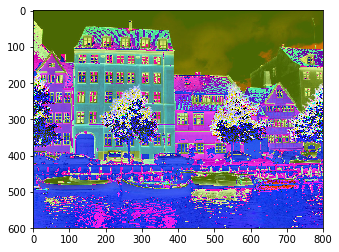

In [18]:
net = build_vgg19(VGG_MODEL)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Generates noise image from content image. 
noise_img = np.random.uniform(-20, 20, (1, IMAGE_H, IMAGE_W, 3)).astype('float32')

# Load content image.
content_img, content_mean_values = read_image(CONTENT_IMG)
print(np.shape(content_img))
print(type(content_img[0,2,2,1]))
plt.imshow(content_img[0])

plt.imsave('test.png',content_img[0])

(600, 800, 3)
<class 'numpy.uint8'>


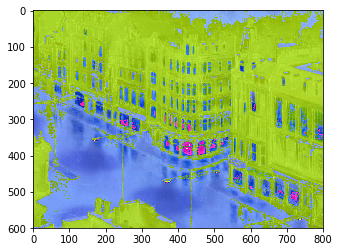

In [19]:
# Load style image.
style_img, style_mean_values = read_image(STYLE_IMG)
imshow(style_img[0])

In [20]:
# Content Loss.  
sess.run([net['input'].assign(content_img)])
cost_content = sum(map(lambda l,: l[1]*build_content_loss(sess.run(net[l[0]]) ,  net[l[0]])
, CONTENT_LAYERS))

# Style Loss.  
sess.run([net['input'].assign(style_img)])
cost_style = sum(map(lambda l: l[1]*build_style_loss(sess.run(net[l[0]]) ,  net[l[0]])
, STYLE_LAYERS))

# Equation 7 (see paper).  
cost_total = cost_content + STYLE_STRENGTH * cost_style
# Minimizes white noise image distance from content image and the painting style image.
optimizer = tf.train.AdamOptimizer(2.0)
# Minize total loss.
train = optimizer.minimize(cost_total)

In [21]:
sess.run(tf.global_variables_initializer())
sess.run(net['input'].assign( INI_NOISE_RATIO* noise_img + (1.-INI_NOISE_RATIO) * content_img))

if not os.path.exists(OUTOUT_DIR):
  os.mkdir(OUTOUT_DIR)

for i in range(ITERATION):
    print('Iteration %d' % (i))
    sess.run(train)
    if i%100 ==0:
      result_img = sess.run(net['input'])
      print('Saving Iteration %d' % (i))
      #print('Sum: ', sess.run(tf.reduce_sum(result_img)))  
      #print('Cost: ', sess.run(cost_total))
      write_image(os.path.join(OUTOUT_DIR,'%s.png'%(str(i).zfill(4))),result_img, content_mean_values)

write_image(os.path.join(OUTOUT_DIR,OUTPUT_IMG),result_img, content_mean_values)

Iteration 0
Saving Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Ite

Iteration 585
Iteration 586
Iteration 587
Iteration 588
Iteration 589
Iteration 590
Iteration 591
Iteration 592
Iteration 593
Iteration 594
Iteration 595
Iteration 596
Iteration 597
Iteration 598
Iteration 599
Iteration 600
Saving Iteration 600
Iteration 601
Iteration 602
Iteration 603
Iteration 604
Iteration 605
Iteration 606
Iteration 607
Iteration 608
Iteration 609
Iteration 610
Iteration 611
Iteration 612
Iteration 613
Iteration 614
Iteration 615
Iteration 616
Iteration 617
Iteration 618
Iteration 619
Iteration 620
Iteration 621
Iteration 622
Iteration 623
Iteration 624
Iteration 625
Iteration 626
Iteration 627
Iteration 628
Iteration 629
Iteration 630
Iteration 631
Iteration 632
Iteration 633
Iteration 634
Iteration 635
Iteration 636
Iteration 637
Iteration 638
Iteration 639
Iteration 640
Iteration 641
Iteration 642
Iteration 643
Iteration 644
Iteration 645
Iteration 646
Iteration 647
Iteration 648
Iteration 649
Iteration 650
Iteration 651
Iteration 652
Iteration 653
Iteration 654